In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from model import *


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
df = pd.read_csv('./data/training_set_features.csv')
df2 = pd.read_csv('./data/training_set_labels.csv')

A test set_feature was provided as well but unfortunately the set_labels that contain the target is with-held for the DataDriven competition. As such for the purposes of model testing, a train-test split will be performed on the training data provided. 

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg


In [5]:
df2

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [7]:
df.education.value_counts()

College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64

In [8]:
df.employment_status.value_counts()

Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64

This makes sense as to why there would be so many missing values for the columns `employment_industry` and `employment_occupation`.

In [9]:
df.health_insurance.value_counts()

1.0    12697
0.0     1736
Name: health_insurance, dtype: int64

In [10]:
df.race.value_counts()
#Do not want to introduce racial bias into this

White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: race, dtype: int64

In [11]:
df.child_under_6_months.value_counts()

0.0    23749
1.0     2138
Name: child_under_6_months, dtype: int64

In [12]:
df.hhs_geo_region.value_counts()

lzgpxyit    4297
fpwskwrf    3265
qufhixun    3102
oxchjgsf    2859
kbazzjca    2858
bhuqouqj    2846
mlyzmhmf    2243
lrircsnp    2078
atmpeygn    2033
dqpwygqj    1126
Name: hhs_geo_region, dtype: int64

**Data is from a 2009 H1N1 Flu survey** 

In [13]:
df.isna().sum().sum()
#too many nulls in general to drop all of them

60762

In [14]:
df2.isna().sum().sum()

0

## Data Cleaning before Train-test split

In [15]:
df3 = pd.concat([df,df2], axis = 1)

In [16]:
df3

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,2,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,3,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,26702,0,0
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,26703,0,0
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,26704,0,1
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg,26705,0,0


In [17]:
26707/10

2670.7

In [18]:
#nulls = 
df3.behavioral_antiviral_meds.value_counts()

0.0    25335
1.0     1301
Name: behavioral_antiviral_meds, dtype: int64

In [19]:
df3.employment_occupation.value_counts()

xtkaffoo    1778
mxkfnird    1509
emcorrxb    1270
cmhcxjea    1247
xgwztkwe    1082
hfxkjkmi     766
qxajmpny     548
xqwwgdyp     485
kldqjyjy     469
uqqtjvyb     452
tfqavkke     388
ukymxvdu     372
vlluhbov     354
oijqvulv     344
ccgxvspp     341
bxpfxfdn     331
haliazsg     296
rcertsgn     276
xzmlyyjv     248
dlvbwzss     227
hodpvpew     208
dcjcmpih     148
pvmttkik      98
Name: employment_occupation, dtype: int64

In [20]:
df3.describe()


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,respondent_id,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,13353.000000,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,7709.791156,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,6676.500000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,13353.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,20029.500000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,26706.000000,1.000000,1.000000


We see that there is of binary or multilabel numericals

In [21]:
df3.h1n1_vaccine.value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

In [22]:
df3.seasonal_vaccine.value_counts()

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

In [23]:
X = df3.drop(['respondent_id','race', 'h1n1_vaccine'],
            axis = 1)
y = df3['h1n1_vaccine']

#### Checking multicolinearity between features due to usage of logistic regression

In [24]:
X

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,seasonal_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,1
26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,18 - 34 Years,Some College,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg,0


###  Train-test-split 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)

In [26]:
X_train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,seasonal_vaccine
15654,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,5.0,4.0,2.0,4.0,4.0,4.0,65+ Years,< 12 Years,Male,Below Poverty,Married,Own,Not in Labor Force,kbazzjca,Non-MSA,1.0,0.0,NaN,NaN,1
14559,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,45 - 54 Years,12 Years,Male,"<= $75,000, Above Poverty",Married,Rent,Employed,kbazzjca,"MSA, Principle City",0.0,0.0,pxcmvdjn,xqwwgdyp,1
13752,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,2.0,1.0,5.0,5.0,1.0,65+ Years,Some College,Male,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,qufhixun,Non-MSA,1.0,0.0,NaN,NaN,1
21985,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,1.0,65+ Years,< 12 Years,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,1.0,0.0,NaN,NaN,0
18196,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,2.0,2.0,5.0,2.0,2.0,65+ Years,12 Years,Male,"<= $75,000, Above Poverty",Married,Rent,Not in Labor Force,fpwskwrf,Non-MSA,1.0,0.0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,18 - 34 Years,Some College,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,3.0,NaN,NaN,0
17289,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,3.0,4.0,4.0,2.0,2.0,35 - 44 Years,College Graduate,Female,"<= $75,000, Above Poverty",NaN,Own,Employed,dqpwygqj,"MSA, Not Principle City",0.0,1.0,pxcmvdjn,xgwztkwe,1
5192,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,2.0,4.0,5.0,4.0,4.0,65+ Years,College Graduate,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,1
12172,3.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,4.0,1.0,5.0,4.0,1.0,55 - 64 Years,Some College,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,Non-MSA,0.0,0.0,atmlpfrs,xqwwgdyp,1


In [27]:
train_df = pd.concat([X_train,y_train], axis =1)

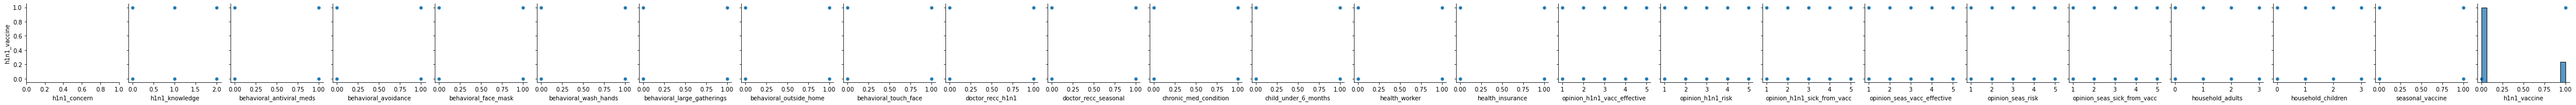

In [28]:
sns.pairplot(train_df, y_vars= 'h1n1_vaccine') #graph makes sense looking at the dictionary for the columns

#### Dummy Regressor for train and test

In [29]:
dummy = DummyClassifier(strategy='most_frequent').fit(X_train,y_train)
dummy.score(X_train,y_train)

0.7873190214677983

In [30]:
dummy.score(X_test, y_test)

0.7882282462183615

78.8% accurate.

#### simple models

how well does just seasonal vaccine predict h1n1 vaccine rates?

In [31]:
X_simple = X_train[['seasonal_vaccine']]
y_simple = y_train

In [32]:
X_sm, y_sm = SMOTE(sampling_strategy= 0.35, random_state=1).fit_resample(X_simple, y_simple)

In [33]:
logreg1 = LogisticRegression(random_state=1).fit(X_sm,y_sm)

In [34]:
logreg1.score(X_simple,y_simple)

0.7873190214677983

In [35]:
sv1 = SVC(random_state=1).fit(X_sm,y_sm)

In [36]:
#ModelWithCV(sv, 'svc', X_simple, y_simple)

In [37]:
sv1.score(X_simple,y_simple)

0.7873190214677983

In [38]:
knn = KNeighborsClassifier().fit(X_sm, y_sm)

In [39]:
knn.score(X_simple, y_simple)

0.6706440339490763

In [40]:
dtree = DecisionTreeClassifier(random_state=1).fit(X_sm,y_sm)

In [41]:
dtree.score(X_simple,y_simple)

0.7873190214677983

Overall, our logistic regression, support vector machine, and decision tree produced about the same accuracy as our dummy. Meaning the defaults and one feature does poorly in predicting who got the h1n1. The KNN does an even worse job at predicting compared to our dummy.

##### let's put multiple default models in voting!

In [42]:
voting = VotingClassifier(estimators= [
    ('lr', logreg1),
    ('sv1', sv1),
    ('knn', knn),
    ('dt', dtree)
]
).fit(X_sm,y_sm)

In [43]:
voting.score(X_simple, y_simple)

0.7873190214677983

Still shit

### setting up pipelines for ohe/scaling and ct for our more complex models

In [44]:
y_train.value_counts(normalize = True)

0    0.787319
1    0.212681
Name: h1n1_vaccine, dtype: float64

Class imbalance

In [45]:
X_train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,seasonal_vaccine
15654,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,5.0,4.0,2.0,4.0,4.0,4.0,65+ Years,< 12 Years,Male,Below Poverty,Married,Own,Not in Labor Force,kbazzjca,Non-MSA,1.0,0.0,NaN,NaN,1
14559,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,45 - 54 Years,12 Years,Male,"<= $75,000, Above Poverty",Married,Rent,Employed,kbazzjca,"MSA, Principle City",0.0,0.0,pxcmvdjn,xqwwgdyp,1
13752,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,2.0,1.0,5.0,5.0,1.0,65+ Years,Some College,Male,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,qufhixun,Non-MSA,1.0,0.0,NaN,NaN,1
21985,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,1.0,65+ Years,< 12 Years,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,1.0,0.0,NaN,NaN,0
18196,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,2.0,2.0,5.0,2.0,2.0,65+ Years,12 Years,Male,"<= $75,000, Above Poverty",Married,Rent,Not in Labor Force,fpwskwrf,Non-MSA,1.0,0.0,NaN,NaN,1


In [46]:
cat_cols =['behavioral_antiviral_meds', 'behavioral_avoidance',
           'behavioral_face_mask','behavioral_wash_hands',
           'behavioral_large_gatherings', 'behavioral_outside_home',
           'behavioral_touch_face', 'doctor_recc_h1n1',
           'doctor_recc_seasonal', 'chronic_med_condition',
           'child_under_6_months', 'health_worker',
           'health_insurance', 'sex', 'income_poverty',
           'marital_status', 'rent_or_own', 'employment_status',
           'hhs_geo_region', 'census_msa', 'household_adults',
           'household_children', 'employment_industry', 'employment_occupation',
           'seasonal_vaccine']

oe_col = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',
                  'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
                  'opinion_seas_vacc_effective', 'opinion_seas_risk',
                  'opinion_seas_sick_from_vacc', 'age_group',
                  'education']
cat_pipe = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
oe_pipe = Pipeline(steps=[('oe_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OrdinalEncoder())])


In [47]:
ct = ColumnTransformer(transformers=[
    ('cat', cat_pipe, X_train[cat_cols].columns),
    ('oe', oe_pipe, X_train[oe_col].columns)
])

In [48]:
#no grid search performed
logreg_pipe = ImPipeline(steps = [
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('logreg', LogisticRegression(random_state=1))
]).fit(X_train,y_train)

C:\Users\xiao\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
logreg_pipe.score(X_train,y_train)

0.8506240639041438

In [50]:
logreg_pipe.score(X_test,y_test)

0.855623783136139

When including all our features the acurracy increases from 78-79% to about 85%.

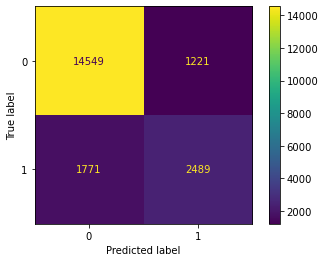

In [51]:
plot_confusion_matrix(logreg_pipe, X_train, y_train)

In [52]:
log_params = {
    'logreg__penalty' : ['l2', 'l1', 'none'],
    'logreg__C' : [1,10,100],
    'logreg__max_iter': [100,500,10000],
    'logreg__solver': ['liblinear', 'saga', 'lbfgs','sag']
}

In [ ]:
log_grid = GridSearchCV(estimator=logreg_pipe, param_grid=log_params, n_jobs=-1).fit(X_train,y_train)

In [ ]:
log_grid.score(X_train,y_train)

In [ ]:
log_grid.best_params_

The best max_iter is a 100 which is our minimun set in the first params, so we adjust the max_iter to be between just 100 - 500.

In [ ]:
log_params_adj = {
    'logreg__penalty' : ['l2', 'l1', 'none'],
    'logreg__C' : [1,10,100],
    'logreg__max_iter': [100,150,200,250,300,350],
    'logreg__solver': ['liblinear', 'saga', 'lbfgs','sag']
}

In [ ]:
log_grid1 = GridSearchCV(estimator=logreg_pipe, param_grid=log_params_adj, n_jobs=-1).fit(X_train,y_train)

In [ ]:
log_grid1.score(X_train,y_train)

In [ ]:
log_grid.best_params_ #same results so we'll go with 100 iter?

In [ ]:
plot_confusion_matrix(log_grid, X_train, y_train)

In [ ]:
#roc_auc_score(y_train, log_grid.predict_proba(X_train))

In [ ]:
log_grid.score(X_test, y_test)

Even when using the best parameters in logistic regression, we performed about the same as the default logistic regression. The train score got better by 0.001 while the test improved by 0.0005, which for us is negible. There is more false negative in grid search version but less false negative when compared to the default.

In [ ]:
knn_pipe = ImPipeline(steps = [
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('knn', KNeighborsClassifier())
]).fit(X_train,y_train)

In [ ]:
knn_pipe.score(X_train,y_train)

In [ ]:
plot_confusion_matrix(knn_pipe, X_train, y_train)

In [ ]:
dt_pipe = ImPipeline(steps = [
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('dt', DecisionTreeClassifier(random_state=1))
]).fit(X_train,y_train)

In [ ]:
dt_pipe.score(X_train, y_train) #super overfit

In [ ]:
svm_pipe = ImPipeline(steps = [
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('svm', SVC(random_state=1))
]).fit(X_train,y_train)

In [ ]:
svm_pipe.score(X_train,y_train)

In [ ]:
plot_confusion_matrix(svm_pipe, X_train, y_train)

In [ ]:
voting_complex = VotingClassifier(estimators= [
    ('lr', logreg_pipe),
    ('sv1', svm_pipe),
    ('knn', knn_pipe),
    ('dt', dt_pipe)
]
).fit(X_train,y_train)

In [ ]:
voting_complex.score(X_train,y_train)

In [ ]:
plot_confusion_matrix(voting_complex, X_train, y_train)

Significant drop in confusing the false positives (1221 from the logistic reg to 479) with the voting complex model. The False negative dropped slightly form 1770 to 1741 and increase in correctly identifying TN and TP.

In [ ]:
#let's try random forest instead of dt since it's super over fit!

#### Final Model

In [ ]:
#fit it with the entire train df

### Testing set

#### Any sort of transformation done on training do on testing

In [ ]:
##SS/OHE

#### Evaluation of the testing set on our final model and comparison of error